In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import scipy
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Dataset

In [2]:
n_samples = 500

# generate random sample, two components
np.random.seed(5)

# generate spherical data centered on (10, 5)
shifted_gaussian = np.random.randn(n_samples, 2) * 3. + np.array([10, 5])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
x = np.vstack([shifted_gaussian, stretched_gaussian])

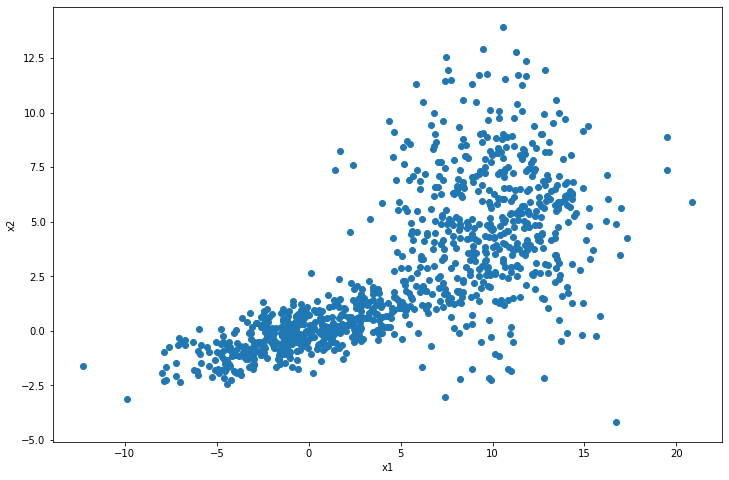

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(x[:,0], x[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [11]:
def make_ellipses(cen, cov, ax):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(cen, v[0], v[1], 180 + angle, color = 'green')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.25)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')

In [12]:
def plot_2d_clusters(centers, covariances, x, clusters = None):
    ax = plt.subplot(1, 1, 1)
    if clusters is None:
        plt.scatter(x[:,0], x[:,1])
    for k in range(len(centers)):
        if clusters is not None:
            plt.scatter(x[:,0][clusters == k], x[:,1][clusters == k])
        make_ellipses(centers[k], covariances[k], ax)
    plt.scatter(centers[:,0], centers[:,1], marker='x', s=100)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

## Sklearn EM

In [13]:
K = 2
em = GaussianMixture(K)
cl = em.fit_predict(x)

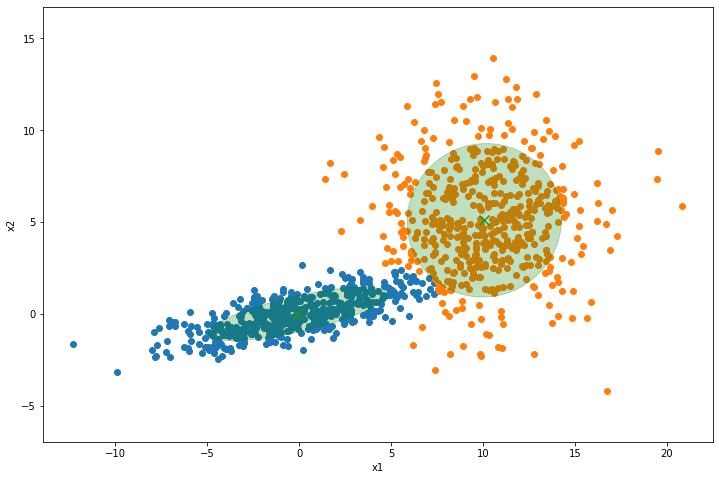

In [14]:
plt.figure(figsize=(12, 8))
plot_2d_clusters(em.means_, em.covariances_, x, cl)

Model final parameters

In [15]:
print("Cluster centers (means):\n")
print(em.means_)

print("\nCluster covariances:\n")
print(em.covariances_)

print("\nCluster weights (priors):\n")
print(em.weights_)

Cluster centers (means):

[[-6.58895517e-02  8.61320988e-03]
 [ 1.00795458e+01  5.10154118e+00]]

Cluster covariances:

[[[11.86458809  2.60235178]
  [ 2.60235178  1.06055689]]

 [[ 8.82080901  0.20241514]
  [ 0.20241514  8.71790821]]]

Cluster weights (priors):

[0.49784013 0.50215987]


Metrics:

In [16]:
print("BIC:", em.bic(x))
print("AIC:", em.aic(x))
print("ll (log-likelihood): ", em.score(x))

BIC: 10064.39177547761
AIC: 10010.406467408808
ll (log-likelihood):  -4.994203233704404


Try more clusters now:

In [17]:
criterions = []
for k in range(1, 21):
    em = GaussianMixture(k)
    em.fit(x)
    criterions.append([k, em.bic(x), em.aic(x)])
criterions = np.array(criterions)

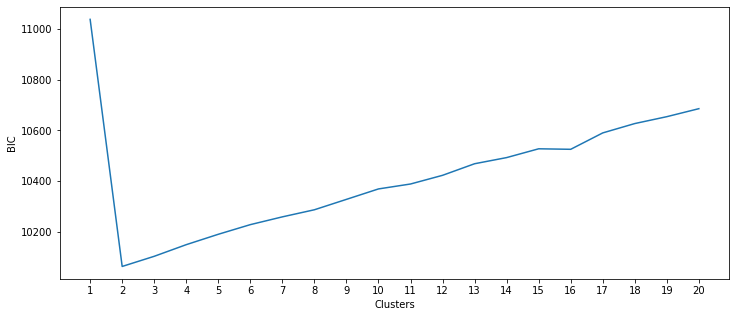

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(criterions[:,0], criterions[:,1])
plt.xticks(np.arange(min(criterions[:,0]), max(criterions[:,0]) + 1, 1.0))
plt.xlabel('Clusters')
plt.ylabel('BIC')
plt.show()

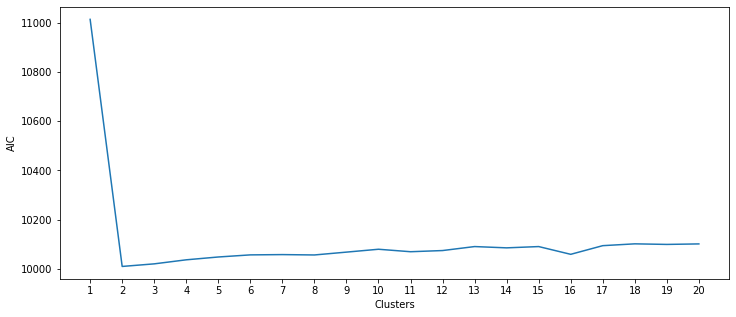

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(criterions[:,0], criterions[:,2])
plt.xticks(np.arange(min(criterions[:,0]), max(criterions[:,0]) + 1, 1.0))
plt.xlabel('Clusters')
plt.ylabel('AIC')
plt.show()

## Gaussian mixture

In [23]:
def normpdf(x, mean, sd):
    var = float(sd) ** 2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num / denom

In [24]:
X_ = np.arange(0, 20, 0.1)
Y1 = np.array([normpdf(x, 5, 1) for x in X_])
Y2 = np.array([normpdf(x, 12, 2) for x in X_])
Y_ = Y1 + Y2

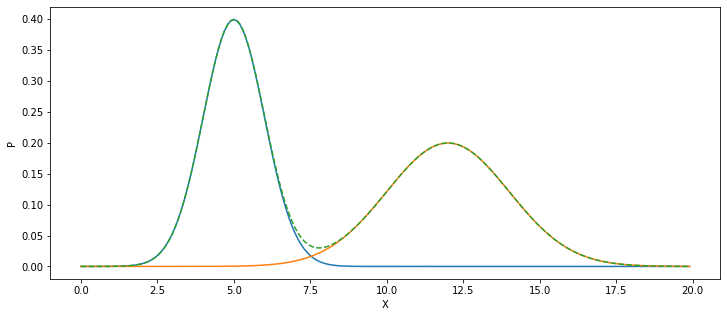

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(X_, Y1)
plt.plot(X_, Y2)
plt.plot(X_, Y_, '--')
plt.xlabel('X')
plt.ylabel('P')
plt.show()

In [129]:
def plot_mix1d(K, X, M, S, Xd, P = None):
    plt.figure(figsize=(12, 5))
    colors = ['b','g','r','c','m','y','b']
    plt.scatter(X, np.zeros_like(X))
    for k in range(K):
        plt.plot(Xd, np.array([normpdf(x, M[k], S[k]) for x in Xd]), color = colors[k])
        if P is not None:
            plt.bar(X + k*0.2, P[:,k], width=0.2, color = colors[k])
    plt.xlabel('X')
    plt.ylabel('P')
    plt.show()

## EM in steps

### Initialize

In [130]:
X_ = np.array([1, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 3.1, 3.2, 7, 7.5, 8, 8.5, 9, 9.5, 10 ])
Xd = np.arange(0, 10, 0.1)
K = 2

In [131]:
M_ = KMeans(K).fit(X_[:,np.newaxis]).cluster_centers_.reshape((K))
M_ = np.array([1., 2.])
S_ = np.ones((K,))
P_ = np.ones((K,)) / K

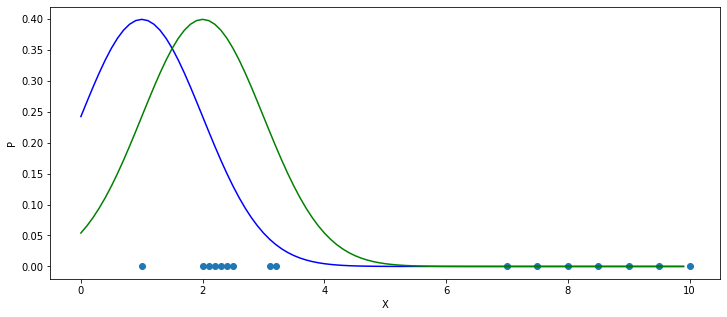

M = [1. 2.]
S = [1. 1.]


In [132]:
plot_mix1d(K, X_, M_, S_, Xd)
print(f'M = {M_}')
print(f'S = {S_}')

### Iteration #1

In [133]:
Px = np.zeros((len(X_),K))
for k in range(K):
    Px[:,k] = np.array([normpdf(x, M_[k], S_[k]) for x in X_])
Px

array([[3.98942280e-01, 2.41970725e-01],
       [2.41970725e-01, 3.98942280e-01],
       [2.17852177e-01, 3.96952547e-01],
       [1.94186055e-01, 3.91042694e-01],
       [1.71368592e-01, 3.81387815e-01],
       [1.49727466e-01, 3.68270140e-01],
       [1.29517596e-01, 3.52065327e-01],
       [4.39835960e-02, 2.17852177e-01],
       [3.54745928e-02, 1.94186055e-01],
       [6.07588285e-09, 1.48671951e-06],
       [2.66955661e-10, 1.07697600e-07],
       [9.13472041e-12, 6.07588285e-09],
       [2.43432053e-13, 2.66955661e-10],
       [5.05227108e-15, 9.13472041e-12],
       [8.16623563e-17, 2.43432053e-13],
       [1.02797736e-18, 5.05227108e-15]])

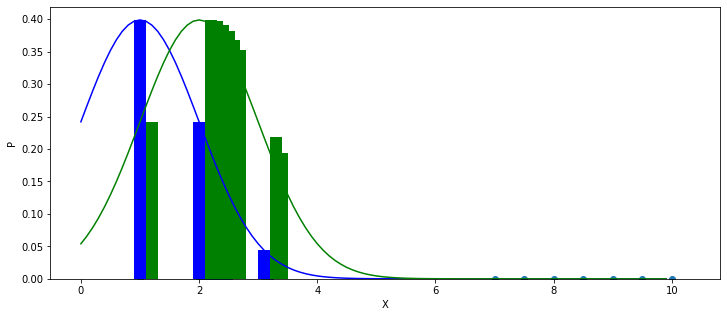

M = [1. 2.]
S = [1. 1.]


In [134]:
plot_mix1d(K, X_, M_, S_, Xd, Px)
print(f'M = {M_}')
print(f'S = {S_}')

In [135]:
a = np.multiply(Px, P_)
b = np.sum(a, axis=1)
Pk = np.divide(a, np.append(b[:,np.newaxis],b[:,np.newaxis],axis=1))
Pk

array([[6.22459331e-01, 3.77540669e-01],
       [3.77540669e-01, 6.22459331e-01],
       [3.54343694e-01, 6.45656306e-01],
       [3.31812228e-01, 6.68187772e-01],
       [3.10025519e-01, 6.89974481e-01],
       [2.89050497e-01, 7.10949503e-01],
       [2.68941421e-01, 7.31058579e-01],
       [1.67981615e-01, 8.32018385e-01],
       [1.54465265e-01, 8.45534735e-01],
       [4.07013772e-03, 9.95929862e-01],
       [2.47262316e-03, 9.97527377e-01],
       [1.50118226e-03, 9.98498818e-01],
       [9.11051194e-04, 9.99088949e-01],
       [5.52778637e-04, 9.99447221e-01],
       [3.35350130e-04, 9.99664650e-01],
       [2.03426978e-04, 9.99796573e-01]])

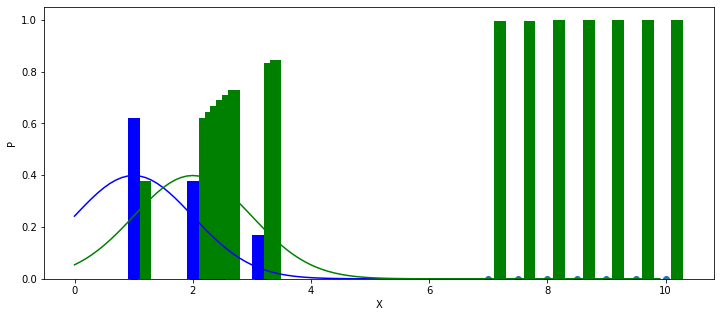

In [136]:
plot_mix1d(K, X_, M_, S_, Xd, Pk)

In [137]:
for k in range(K):
    M_[k] = np.sum(np.multiply(Pk[:,k], X_)) / np.sum(Pk[:,k])
M_

array([2.0864198 , 5.66425027])

In [138]:
for k in range(K):
    S_[k] = np.sum(np.multiply(Pk[:,k], np.power(X_ - M_[k], 2))) / np.sum(Pk[:,k])
S_

array([0.52407978, 9.86373259])

In [139]:
P_ = np.sum(Pk, axis = 0) / len(X_)
P_

array([0.18041667, 0.81958333])

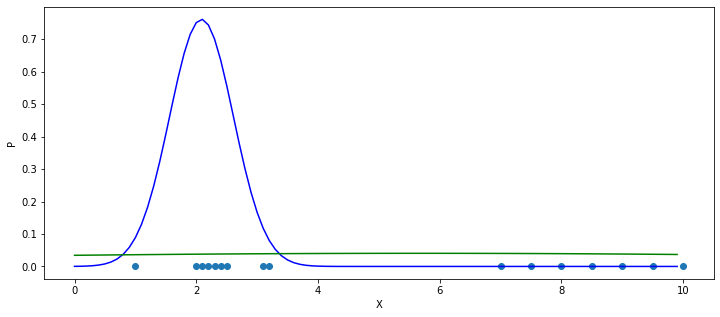

M = [2.0864198  5.66425027]
S = [0.52407978 9.86373259]


In [140]:
plot_mix1d(K, X_, M_, S_, Xd)
print(f'M = {M_}')
print(f'S = {S_}')

### Iteration #2

In [141]:
Px = np.zeros((len(X_),K))
for k in range(K):
    Px[:,k] = np.array([normpdf(x, M_[k], S_[k]) for x in X_])

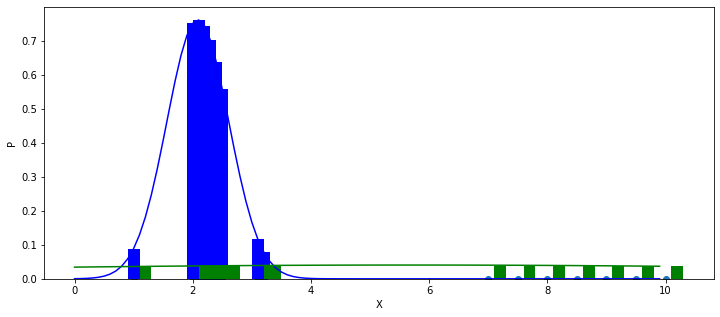

In [142]:
plot_mix1d(K, X_, M_, S_, Xd, Px)

In [143]:
a = np.multiply(Px, P_)
b = np.sum(a, axis=1)
Pk = np.divide(a, np.append(b[:,np.newaxis],b[:,np.newaxis],axis=1))
Pk

array([[3.50823195e-01, 6.49176805e-01],
       [8.14097022e-01, 1.85902978e-01],
       [8.15537289e-01, 1.84462711e-01],
       [8.11477465e-01, 1.88522535e-01],
       [8.01639418e-01, 1.98360582e-01],
       [7.85363341e-01, 2.14636659e-01],
       [7.61609036e-01, 2.38390964e-01],
       [3.97720045e-01, 6.02279955e-01],
       [3.09000977e-01, 6.90999023e-01],
       [3.41602687e-19, 1.00000000e+00],
       [2.84910577e-23, 1.00000000e+00],
       [9.58758764e-28, 1.00000000e+00],
       [1.30173806e-32, 1.00000000e+00],
       [7.13101486e-38, 1.00000000e+00],
       [1.57613191e-43, 1.00000000e+00],
       [1.40555311e-49, 1.00000000e+00]])

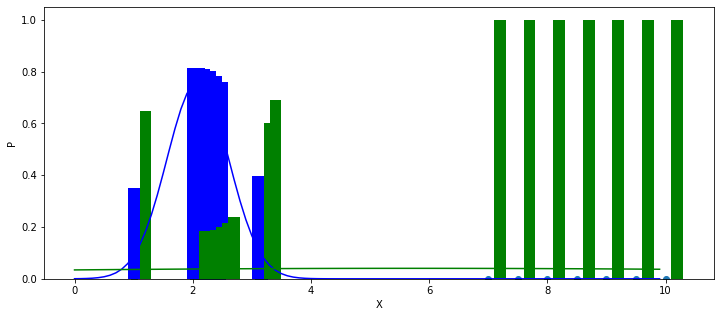

In [144]:
plot_mix1d(K, X_, M_, S_, Xd, Pk)

In [145]:
for k in range(K):
    M_[k] = np.sum(np.multiply(Pk[:,k], X_)) / np.sum(Pk[:,k])
M_

array([2.27991893, 6.59612625])

In [146]:
for k in range(K):
    S_[k] = np.sum(np.multiply(Pk[:,k], np.power(X_ - M_[k], 2))) / np.sum(Pk[:,k])
S_

array([0.21337964, 8.94084584])

In [147]:
P_ = np.sum(Pk, axis = 0) / len(X_)
P_

array([0.36545424, 0.63454576])

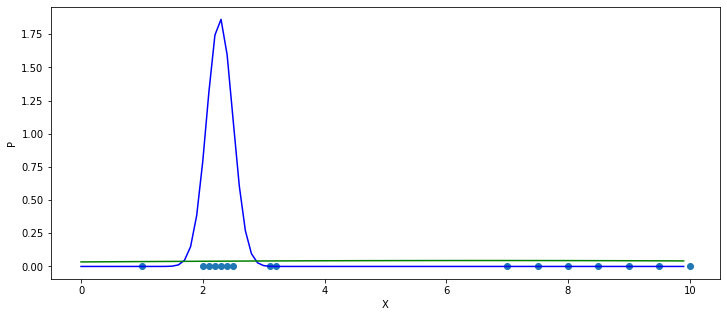

M = [2.27991893 6.59612625]
S = [0.21337964 8.94084584]


In [148]:
plot_mix1d(K, X_, M_, S_, Xd)
print(f'M = {M_}')
print(f'S = {S_}')

## EM algorithm

In [149]:
def E_step(K, X, M, S):
    P1 = np.zeros((len(X),K))
    for k in range(K):
        P1[:,k] = np.array([normpdf(x, M[k], S[k]) for x in X])
    return P1

In [150]:
def M_step(K, X, P0, P1):
    
    a = np.multiply(P0, P1)
    b = np.sum(a, axis=1)
    P = np.divide(a, np.append(b[:,np.newaxis], b[:,np.newaxis],axis=1))
    
    M = np.zeros((K))
    S = np.zeros((K))
    
    for k in range(K):
        M[k] = np.sum(np.multiply(P[:,k], X)) / np.sum(P[:,k])
        S[k] = np.sum(np.multiply(P[:,k], np.power(X - M[k], 2))) / np.sum(P[:,k])
    
    P0 = np.sum(P, axis = 0) / len(P)
    
    return M, S, P0

In [151]:
def EM1d(K, X):
    
    M  = KMeans(K).fit(X[:,np.newaxis]).cluster_centers_.reshape((K))
    S  = np.ones((K)).astype(float)
    P0 = np.zeros((K)).astype(float)
    P0[:] = 1/K
    
    while True:
        
        M_prev = np.copy(M)
        S_prev = np.copy(S)
        
        P1 = E_step(K, X, M, S)
        
#         plot_mix1d(K, X, M, S, Xd, P1)
#         print(f'M = {M}')
#         print(f'S = {S}')

        M, S, P0 = M_step(K, X, P0, P1)
        
        if np.all(M_prev == M) and np.all(S_prev == S): break
            
    return M, S, P1

In [152]:
M, S, P = EM1d(2, X_)

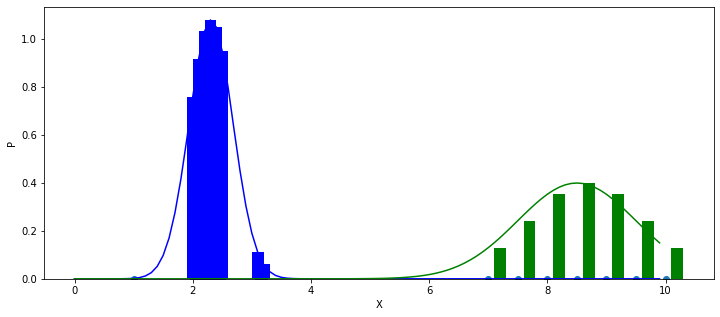

M = [2.31111059 8.49999588]
S = [0.36987632 1.00002119]


In [153]:
plot_mix1d(K, X_, M, S, Xd, P)
print(f'M = {M}')
print(f'S = {S}')

### Sklearn EM

In [154]:
em = GaussianMixture(K)
cl = em.fit_predict(X_[:,np.newaxis])

In [155]:
print(f'M = {np.squeeze(em.means_).tolist()}')
print(f'S = {np.squeeze(em.covariances_).tolist()}')

M = [8.499998763598828, 2.311110958103801]
S = [1.000007371869452, 0.36987747839289437]


# Multivariate EM steps

In [156]:
def normpdf_mv(x, mu, cov):
    assert(len(mu.shape) == 1), 'mu must be a row vector'
    assert(len(x.shape) == 1), 'x must be a row vector'
    assert(cov.shape[0] == cov.shape[1]), 'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]), 'cov_mat and mu_vec must have the same dimensions'
    assert(mu.shape[0] == x.shape[0]), 'mu and x must have the same dimensions'
    part1 = 1 / ( ((2 * np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [157]:
X = np.array([
    [3,9],[5,5],[5,8],[6,11],[7,8],[8,10],[10,1],
    [12,8],[15,2],[15,5],[18,2],[18,5],[19,8],[21,7]]).astype(float)
X

array([[ 3.,  9.],
       [ 5.,  5.],
       [ 5.,  8.],
       [ 6., 11.],
       [ 7.,  8.],
       [ 8., 10.],
       [10.,  1.],
       [12.,  8.],
       [15.,  2.],
       [15.,  5.],
       [18.,  2.],
       [18.,  5.],
       [19.,  8.],
       [21.,  7.]])

In [158]:
K = 2
M = KMeans(K).fit(X).cluster_centers_
M

array([[ 7.        ,  7.5       ],
       [17.66666667,  4.83333333]])

In [159]:
d = X.shape[1]
S = np.array([np.eye(d),np.eye(d)])
S

array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]])

In [160]:
P0 = np.zeros((K)).astype(float)
P0[:] = 1/K
P0

array([0.5, 0.5])

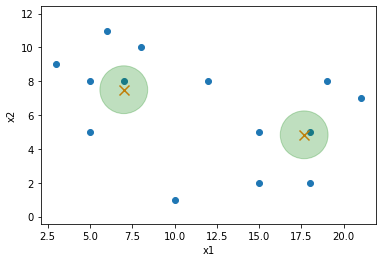

In [161]:
plot_2d_clusters(M, S, X)

In [162]:
normpdf_mv(X[0,:], M[0,:], S[0,:])

1.7333369068491366e-05

In [163]:
P1 = np.zeros((len(X),K))
for k in range(K):
    P1[:,k] = np.array([normpdf_mv(x, M[k], S[k]) for x in X])
P1

array([[1.73333691e-05, 5.26160787e-52],
       [9.46369885e-04, 2.26840098e-36],
       [1.90083473e-02, 1.52843656e-38],
       [2.11163664e-04, 2.44366049e-39],
       [1.40453744e-01, 2.07866895e-28],
       [4.24133557e-03, 1.30014526e-27],
       [1.18310702e-12, 1.76819350e-17],
       [5.23422392e-07, 1.12583999e-10],
       [5.44117472e-22, 8.21206122e-05],
       [8.85577257e-17, 4.48363351e-03],
       [2.28191749e-34, 2.71946119e-03],
       [3.71393006e-29, 1.48477550e-01],
       [7.55667291e-33, 4.34786764e-04],
       [3.86077147e-44, 5.88419899e-05]])

In [164]:
a = np.multiply(P0, P1)
b = np.sum(a, axis=1)
P = np.divide(a, np.append(b[:,np.newaxis], b[:,np.newaxis],axis=1))
P

array([[1.00000000e+00, 3.03553674e-47],
       [1.00000000e+00, 2.39694967e-33],
       [1.00000000e+00, 8.04087035e-37],
       [1.00000000e+00, 1.15723531e-35],
       [1.00000000e+00, 1.47996692e-27],
       [1.00000000e+00, 3.06541476e-25],
       [9.99985055e-01, 1.49451152e-05],
       [9.99784954e-01, 2.15045803e-04],
       [6.62583312e-18, 1.00000000e+00],
       [1.97513302e-14, 1.00000000e+00],
       [8.39106476e-32, 1.00000000e+00],
       [2.50134115e-28, 1.00000000e+00],
       [1.73801816e-29, 1.00000000e+00],
       [6.56125239e-40, 1.00000000e+00]])

In [165]:
d = X.shape[1]

M = np.zeros((K,d))
for k in range(K):
    for i in range(d):
        M[k,i] = np.sum(np.multiply(P[:,k], X[:,i])) / np.sum(P[:,k])
M

array([[ 6.99985999,  7.4999987 ],
       [17.66644448,  4.83343728]])

In [166]:
S = np.zeros((K,d,d))
for k in range(K):
    for i in range(d):
        for j in range(d):
            S[k,j,i] = np.sum(P[:,k] * (X[:,i] - M[k,i]) * (X[:,j] - M[k,j])) / (len(P) * np.sum(P[:,k]))
S

array([[[ 0.53568048, -0.17857876],
        [-0.17857876,  0.62501185]],

       [[ 0.32547701,  0.21026869],
        [ 0.21026869,  0.36707771]]])

In [167]:
P0 = np.sum(P, axis = 0) / len(P)
P0

array([0.57141214, 0.42858786])

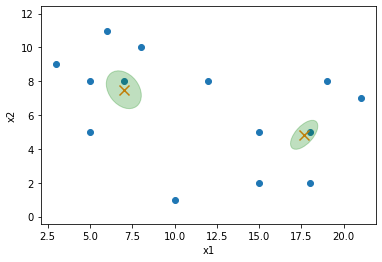

In [168]:
plot_2d_clusters(M, S, X)

## Mulativariate EM

In [169]:
def E_step_mv(K, X, M, S, P0):
    
    P1 = np.zeros((len(X),K))
    for k in range(K):
        P1[:,k] = np.array([normpdf_mv(x, M[k], S[k]) for x in X])
        
    a = np.multiply(P0, P1)
    b = np.sum(a, axis=1)

    P = np.zeros((len(X),K))
    for k in range(K):
        P[:,k] = np.divide(a[:,k], b)
        
    return P

In [170]:
def M_step_mv(K, X, P):
    
    d = X.shape[1]
    
    M = np.zeros((K,d))
    S = np.zeros((K,d,d))

    for k in range(K):
        for i in range(d):
            M[k,i] = np.sum(np.multiply(P[:,k], X[:,i])) / np.sum(P[:,k])
            for j in range(d):
                S[k,i,j] = np.sum(P[:,k] * (X[:,i] - M[k,i]) * (X[:,j] - M[k,j])) / np.sum(P[:,k])
            
    P0 = np.sum(P, axis = 0) / len(P)
    
    return M, S, P0

In [171]:
def EMnd(K, X):
    
    d = X.shape[1]
    M = KMeans(K).fit(X).cluster_centers_
    S = np.array([np.eye(d) for i in range(K)])

    P0 = np.zeros((K)).astype(float)
    P0[:] = 1/K
    
    while True:
        
        M_prev = np.copy(M)
        S_prev = np.copy(S)
        
        P = E_step_mv(K, X, M, S, P0)
        
#         plot_2d_clusters(M, S, X)
#         print(f'M = {M}')
#         print(f'S = {S}')

        M, S, P0 = M_step_mv(K, X, P)
        
        if abs(np.sum(np.subtract(M_prev,M)) + np.sum(np.subtract(S_prev,S))) < 1e-5: break
            
    return M, S, P

In [172]:
M, S, P = EMnd(2, X)
M

array([[ 7.0501436 ,  7.50163308],
       [17.64847079,  4.81883783]])

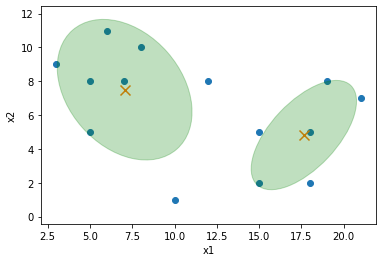

In [173]:
plot_2d_clusters(M, S, X)

In [174]:
em = GaussianMixture(K)
cl = em.fit_predict(X)

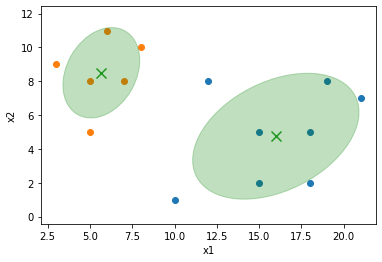

array([[15.99015648,  4.75002267],
       [ 5.67034597,  8.50340512]])

In [175]:
plot_2d_clusters(em.means_, em.covariances_, X, cl)
em.means_

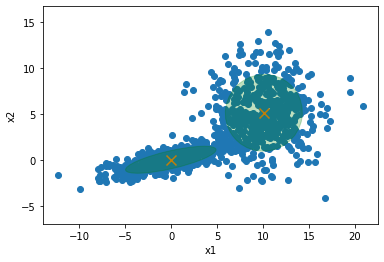

In [176]:
M, S, P = EMnd(2, x)
plot_2d_clusters(M, S, x)

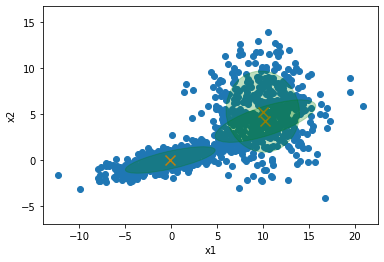

In [177]:
M, S, P = EMnd(3, x)
plot_2d_clusters(M, S, x)